In [1]:
#import the module
from tshirt.pipeline import spec_pipeline
from tshirt.pipeline.instrument_specific import hst_inst_funcs

import matplotlib.pyplot as plt
%matplotlib inline

#import bokeh to enable interactive plots
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show

output_notebook()

#import yaml to read in the parameter file
import yaml

#imports to use RECTE
import os
from astropy.table import QTable
import astropy.units as u
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table, join
import pandas as pd
from astropy.time import Time


#import to copy
from copy import deepcopy

#modeling light curves
from scipy.optimize import curve_fit
import batman

#to fix errors
import pdb

#to correct for time differences
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation

#from importlib import reload
#reload(spec_pipeline)

Loading BokehJS ...

In [2]:
spec = spec_pipeline.spec('corot1_visit1_transit.yaml')

/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/tshirt/pipeline/spec_pipeline.py:133: UserWarning: Deprecated parameter bkgSubY used in parameter file. Setting bkgSubDirections to [Y]
  warnings.warn('Deprecated parameter bkgSubY used in parameter file. Setting bkgSubDirections to [{}]'.format(' '.join(bkgSubDirections)))


In [25]:
#spec.do_extraction()

In [26]:
spec.param['lowPassFreqCC'] = 0.5
spec.param['hiPassFreqCC'] = 0.05
spec.param['nOffsetCC'] = 3

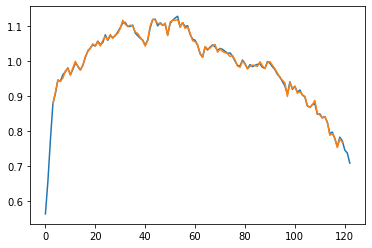

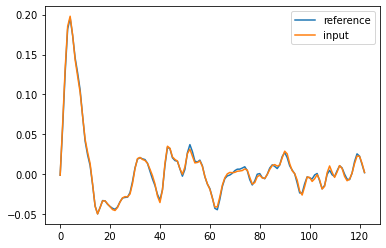

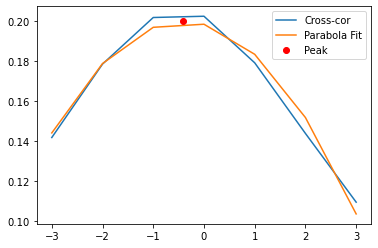

Shift = -0.40712109922735573, or index -0.40712109922735573


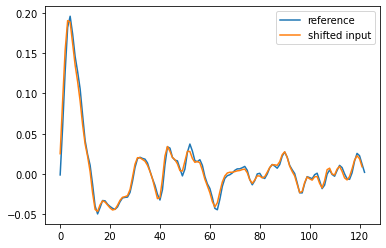

> /home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/tshirt/pipeline/spec_pipeline.py(1098)align_spec()
-> align2D[imgInd,:] = analysis.roll_pad(data2D[imgInd,:],offsetInd * self.param['specShiftMultiplier'])
(Pdb) q


BdbQuit: 

In [28]:
spec.plot_dynamic_spec(showPlot=True,align=True,alignDiagnostics=True)

/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/tshirt/pipeline/spec_pipeline.py:1189: RuntimeWarning: Mean of empty slice
  avgSpec = np.nanmean(useSpec,0)
/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/tshirt/pipeline/spec_pipeline.py:1194: RuntimeWarning: divide by zero encountered in true_divide
  avgSpec_err = np.sqrt(np.nansum(errSpec**2,0)) / np.nansum(specCounts,0)


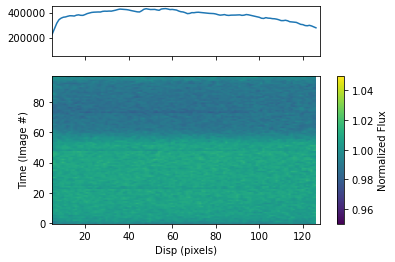

In [29]:
spec.plot_dynamic_spec(showPlot=True,align=True,alignDiagnostics=False)

In [30]:
spec.plot_wavebin_series(nbins=10,interactive=True)

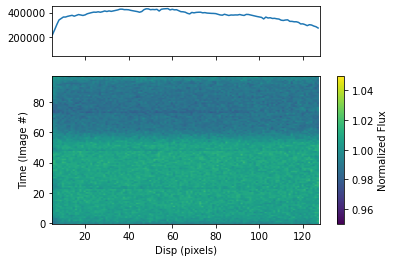

In [31]:
spec.plot_dynamic_spec(showPlot=True,align=False,alignDiagnostics=False)

In [32]:
spec.plot_wavebin_series(nbins=10,interactive=True)

In [38]:
def planck(x, T):
    """ Blackbody as a function of wavelength (um) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    from scipy.constants import h,k,c
    #x is in microns
    return 2*h*c**2 / (x**5 * (np.exp(h*c / (x*k*T)) - 1))

In [40]:
#table_noise_v2=spec_v2.print_noise_wavebin(nbins=10)
#x = table_noise_v2['Disp Mid']
#wavebins = 1.387 + 0.00465 * (x - 64) #in microns

wa = np.linspace(0.1, 2, 100)   # wavelengths in um

T1 = 5000.
T2 = 8000.
y1 = blackbody_lam(wa, T1)
y2 = blackbody_lam(wa, T2)
ytot = y1 + y2

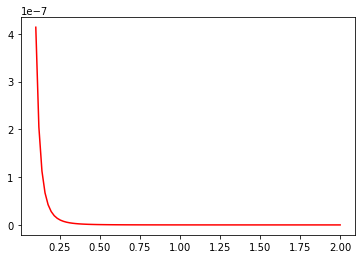

In [44]:
intensity4000 = planck(wa, 5000)
plt.plot(wa, intensity4000, 'r-') 


/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


Text(0, 0.5, 'Intensity (erg/s/cm$^2$/cm/Steradian)')

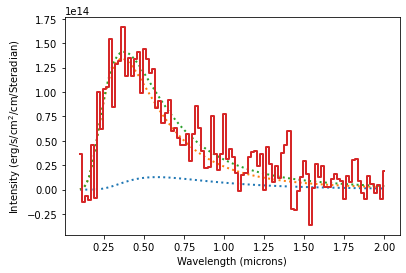

In [49]:
from scipy.optimize import curve_fit
import pylab as plt
import numpy as np

def blackbody_lam(lam, T):
    """ Blackbody as a function of wavelength (um) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    from scipy.constants import h,k,c
    lam = 1e-6 * lam # convert to metres
    return 2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))

wa = np.linspace(0.1, 2, 100)   # wavelengths in um
T1 = 5000.
T2 = 8000.
y1 = blackbody_lam(wa, T1)
y2 = blackbody_lam(wa, T2)
ytot = y1 + y2

np.random.seed(1)

# make synthetic data with Gaussian errors

sigma = np.ones(len(wa)) * 1 * np.median(ytot)
ydata = ytot + np.random.randn(len(wa)) * sigma

# plot the input model and synthetic data

plt.figure()
plt.plot(wa, y1, ':', lw=2, label='T1=%.0f' % T1)
plt.plot(wa, y2, ':', lw=2, label='T2=%.0f' % T2)
plt.plot(wa, ytot, ':', lw=2, label='T1 + T2\n(true model)')
plt.plot(wa, ydata, ls='steps-mid', lw=2, label='Fake data')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Intensity (erg/s/cm$^2$/cm/Steradian)')

In [50]:
# fit two blackbodies to the synthetic data

def func(wa, T1, T2):
    return blackbody_lam(wa, T1) + blackbody_lam(wa, T2)

# Note the initial guess values for T1 and T2 (p0 keyword below). They
# are quite different to the known true values, but not *too*
# different. If these are too far away from the solution curve_fit()
# will not be able to find a solution. This is not a Python-specific
# problem, it is true for almost every fitting algorithm for
# non-linear models. The initial guess is important!

popt, pcov = curve_fit(func, wa, ydata, p0=(1000, 3000), sigma=sigma)

# get the best fitting parameter values and their 1 sigma errors
# (assuming the parameters aren't strongly correlated).

bestT1, bestT2 = popt
sigmaT1, sigmaT2 = np.sqrt(np.diag(pcov))

ybest = blackbody_lam(wa, bestT1) + blackbody_lam(wa, bestT2)

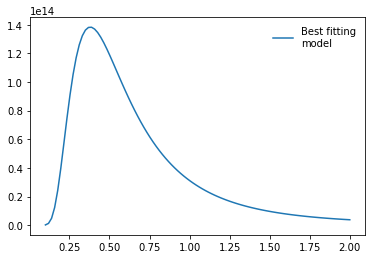

In [51]:
# plot the solution

plt.plot(wa, ybest, label='Best fitting\nmodel')
plt.legend(frameon=False)
plt.show()

In [52]:
ydata

array([ 3.62584686e+13, -1.22002911e+13, -6.40293840e+12, -1.02714956e+13,
        4.56006889e+13, -8.35287424e+12,  9.96852718e+13,  6.21970502e+13,
        1.02916260e+14,  1.04663405e+14,  1.54238092e+14,  8.46875347e+13,
        1.29213423e+14,  1.31327319e+14,  1.66417602e+14,  1.16452956e+14,
        1.35294271e+14,  1.16781332e+14,  1.33544989e+14,  1.41282900e+14,
        9.92159791e+13,  1.44139836e+14,  1.33657331e+14,  1.19664715e+14,
        1.23409215e+14,  8.31977697e+13,  9.07564140e+13,  6.79600422e+13,
        7.82228143e+13,  9.15676584e+13,  6.02400689e+13,  6.27987769e+13,
        5.25558106e+13,  4.54478114e+13,  4.59031905e+13,  5.73057376e+13,
        2.97272788e+13,  5.68713642e+13,  8.58137765e+13,  6.28729707e+13,
        3.97206875e+13,  2.19946568e+13,  2.29718401e+13,  7.51331346e+13,
        3.67722267e+13,  1.97043574e+13,  3.64013117e+13,  7.72120470e+13,
        3.17352480e+13,  4.13574758e+13,  3.29805000e+13,  1.72303752e+13,
       -1.51047605e+12,  

In [29]:
from tshirt.pipeline import spec_pipeline
from importlib import reload
reload(spec_pipeline)

<module 'tshirt.pipeline.spec_pipeline' from '/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/tshirt/pipeline/spec_pipeline.py'>

In [4]:
#wavebins values 
xc0_v1 = 75.36  
yc0_v1 = 71.57

xc0_v2 = 73.593  
yc0_v2 = 73.2098 

xc0_v3 = 75.0211
yc0_v3= 71.4784

xc0_v4=75.3891
yc0_v4=71.4633

#calibrations 
table_noise_v1=spec.print_noise_wavebin(nbins=10)


dismid_v1 = table_noise_v1['Disp Mid']

wavebins_v1 = spec.wavecal(dismid_v1,xc0=xc0_v1,yc0=yc0_v1,waveCalMethod = 'wfc3Dispersion')
wavebins_v1

array([1.12051617, 1.17651281, 1.23250945, 1.29083929, 1.34916912,
       1.40516576, 1.46349559, 1.52182542, 1.57782206, 1.6361519 ])

In [35]:
from tshirt.pipeline.instrument_specific import hst_inst_funcs
from importlib import reload
reload(hst_inst_funcs)

<module 'tshirt.pipeline.instrument_specific.hst_inst_funcs' from '/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/tshirt/pipeline/instrument_specific/hst_inst_funcs.py'>